In [ ]:
pip install python-binance

In [ ]:
import os
import numpy as np
import pandas as pd
import logging
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import cvxpy as cp
from binance.client import Client
import matplotlib.pyplot as plt


In [ ]:
# Replace these with your Binance API keys
api_key = 'test'
api_secret = 'test'

client = Client(api_key, api_secret)

Epoch 1/50
82/82 [==============================] - 12s 16ms/step - loss: 0.0548
Epoch 2/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0015
Epoch 3/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0015
Epoch 4/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0015
Epoch 5/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0015
Epoch 6/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0015
Epoch 7/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0015
Epoch 8/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0015
Epoch 9/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0015
Epoch 10/50
82/82 [==============================] - 1s 13ms/step - loss: 0.0015
Epoch 11/50
82/82 [==============================] - 1s 17ms/step - loss: 0.0015
Epoch 12/50
82/82 [==============================] - 2s 19ms/step - loss: 0.0016
Epoch 13/50
82/82 [=================

1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 817ms/step


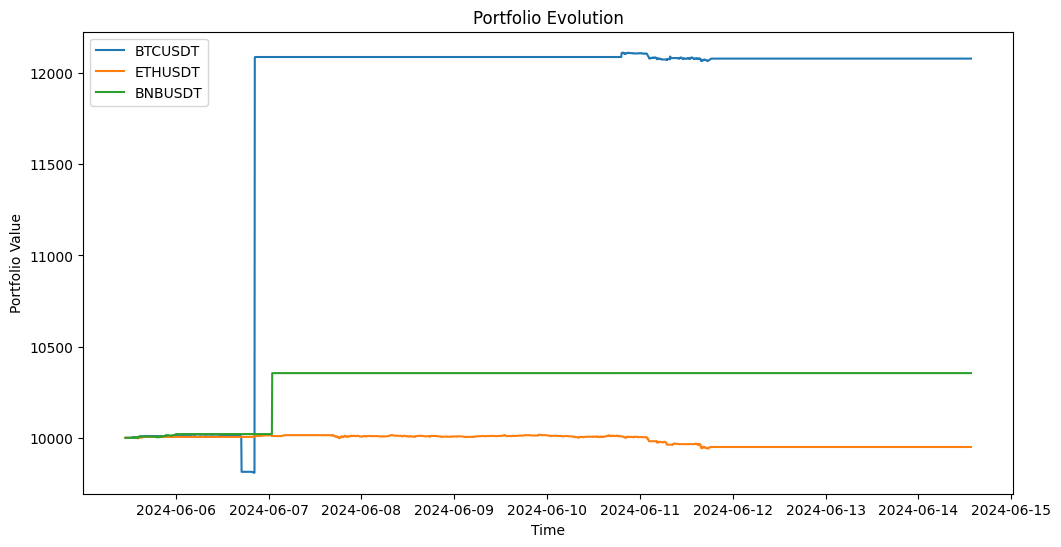

Trade Logs:
        Asset           Type     Price                Time
0     BTCUSDT            buy  70709.12 2024-06-05 12:30:00
1     BTCUSDT  take profit 1  70939.99 2024-06-05 12:40:00
2     BTCUSDT  take profit 1  71006.20 2024-06-05 12:45:00
3     BTCUSDT  take profit 1  71053.43 2024-06-05 12:50:00
4     BTCUSDT  take profit 1  70984.02 2024-06-05 12:55:00
...       ...            ...       ...                 ...
3610  BNBUSDT  take profit 1    693.40 2024-06-08 08:40:00
3611  BNBUSDT  take profit 1    693.70 2024-06-08 08:45:00
3612  BNBUSDT  take profit 1    693.60 2024-06-08 08:50:00
3613  BNBUSDT  take profit 1    693.10 2024-06-08 08:55:00
3614  BNBUSDT  take profit 1    692.90 2024-06-08 09:45:00

[3615 rows x 4 columns]

Summary:
   Overall Return  Sharpe Ratio  Final Portfolio Value
0     2383.591835      1.142919           32383.591835

Buy and Sell Signals:
      Asset Signal                Time
0   BTCUSDT    Buy 2024-06-05 12:30:00
1   BTCUSDT    Buy 2024-06-05 14:0

In [ ]:
# Logging configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Data Fetching
def get_historical_data(symbol, interval='5m', lookback='1 month ago UTC'):
    try:
        bars = client.get_historical_klines(symbol, interval, lookback)
        df = pd.DataFrame(bars, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        return df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    except Exception as e:
        logger.error(f"Error fetching data for {symbol}: {e}")
        return pd.DataFrame()

# Prepare data for LSTM
def prepare_data(data, look_back=10):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['close'].values.reshape(-1, 1))
    X, Y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        Y.append(scaled_data[i, 0])
    return np.array(X).reshape(-1, look_back, 1), np.array(Y), scaler

# Build LSTM Model
def build_lstm_model(input_shape=(10, 1)):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Portfolio Optimization
def optimize_portfolio(returns, covariance_matrix, risk_aversion=0.5):
    n = returns.shape[0]
    weights = cp.Variable(n)
    objective = cp.Maximize(returns.T @ weights - risk_aversion * cp.quad_form(weights, covariance_matrix))
    constraints = [cp.sum(weights) == 1, weights >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return weights.value

# Calculate Bollinger Bands
def bollinger_bands(prices, window=20, num_std_dev=2):
    rolling_mean = prices.rolling(window=window).mean()
    rolling_std = prices.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    return rolling_mean, upper_band, lower_band

# Trading Simulation based on Bollinger Bands
def simulate_trades(prices, sma, upper_band, lower_band, initial_balance=10000, position_size=0.1):
    balance = initial_balance
    position = 0
    trade_log = []
    buy_signals = pd.Series([False] * len(prices), index=prices.index)
    sell_signals = pd.Series([False] * len(prices), index=prices.index)
    portfolio_value = []

    for i in range(1, len(prices)):
        if position == 0:  # No current position
            if prices[i] < lower_band[i]:
                position = balance * position_size / prices[i]
                balance -= position * prices[i]
                entry_price = prices[i]
                tp1_price = sma[i]
                tp2_price = upper_band[i]
                sl_price = prices[i] * 0.995
                trade_log.append({'type': 'buy', 'price': prices[i], 'time': prices.index[i]})
                buy_signals.iloc[i] = True
        elif position > 0:  # Have a long position
            if prices[i] > tp1_price:
                balance += position * prices[i] * 0.5
                position *= 0.5
                trade_log.append({'type': 'take profit 1', 'price': prices[i], 'time': prices.index[i]})
                sl_price = entry_price  # Move stop loss to entry price
            elif prices[i] > tp2_price:
                balance += position * prices[i]
                position = 0
                trade_log.append({'type': 'take profit 2', 'price': prices[i], 'time': prices.index[i]})
                sell_signals.iloc[i] = True
            elif prices[i] < sl_price:
                balance += position * prices[i]
                position = 0
                trade_log.append({'type': 'stop loss', 'price': prices[i], 'time': prices.index[i]})
                sell_signals.iloc[i] = True
        portfolio_value.append(balance + position * prices[i] if position > 0 else balance)

    final_balance = balance + position * prices[-1] if position > 0 else balance
    return trade_log, final_balance, portfolio_value, buy_signals, sell_signals

# Predict returns using LSTM models
def predict_returns(models, data, look_back=10):
    returns = []
    for asset, model in models.items():
        X, _, scaler = prepare_data(data[asset], look_back)
        pred = model.predict(X[-1].reshape(1, look_back, 1))
        returns.append(scaler.inverse_transform(pred).flatten()[0])
    return np.array(returns)

# Adjust weights based on trading performance
def adjust_weights_based_on_performance(weights, trade_logs, assets, threshold=0.6):
    adjusted_weights = np.copy(weights)
    for i, asset in enumerate(assets):
        successful_trades = len([log for log in trade_logs[asset] if log['type'] in ['take profit 1', 'take profit 2']])
        total_trades = len(trade_logs[asset])
        success_rate = successful_trades / total_trades if total_trades > 0 else 0

        if success_rate >= threshold:
            adjusted_weights[i] *= 1.1  # Increase weight by 10%
        else:
            adjusted_weights[i] *= 0.9  # Decrease weight by 10%
        adjusted_weights[i] = max(min(adjusted_weights[i], 1), 0)  # Keep weights within 0 and 1

    return adjusted_weights / adjusted_weights.sum()  # Normalize weights to sum to 1

# Calculate Sharpe Ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0):
    return (np.mean(returns) - risk_free_rate) / np.std(returns)

# Backtesting Function
def backtest(data, assets, look_back=10, initial_balance=10000):
    trade_logs = {}
    portfolio_values = {asset: [] for asset in assets}
    buy_signals = {}
    sell_signals = {}

    for asset in assets:
        sma, upper_band, lower_band = bollinger_bands(data[asset]['close'])
        trade_log, final_balance, portfolio_value, buys, sells = simulate_trades(data[asset]['close'], sma, upper_band, lower_band, initial_balance)
        trade_logs[asset] = trade_log
        portfolio_values[asset] = portfolio_value
        buy_signals[asset] = buys
        sell_signals[asset] = sells

    overall_return = sum([portfolio_values[asset][-1] for asset in assets]) - initial_balance * len(assets)
    sharpe_ratio = calculate_sharpe_ratio([log['price'] for asset in assets for log in trade_logs[asset] if log['type'] in ['take profit 1', 'take profit 2', 'stop loss']])

    # Plot portfolio evolution
    plt.figure(figsize=(12, 6))
    for asset in assets:
        plt.plot(data[asset].index[-len(portfolio_values[asset]):], portfolio_values[asset], label=asset)

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Portfolio Value')
    plt.title('Portfolio Evolution')
    plt.show()

    return trade_logs, overall_return, sharpe_ratio, buy_signals, sell_signals, portfolio_values

def present_trade_logs(trade_logs):
    all_trades = []
    for asset, logs in trade_logs.items():
        for log in logs:
            all_trades.append({
                'Asset': asset,
                'Type': log['type'],
                'Price': log['price'],
                'Time': log['time']
            })
    trades_df = pd.DataFrame(all_trades)
    return trades_df

def present_summary(overall_return, sharpe_ratio, final_balances):
    summary = {
        'Overall Return': [overall_return],
        'Sharpe Ratio': [sharpe_ratio],
        'Final Portfolio Value': [sum(final_balances.values())]
    }
    summary_df = pd.DataFrame(summary)
    return summary_df

def present_signals(buy_signals, sell_signals):
    signals = []
    for asset in buy_signals:
        buy_df = buy_signals[asset][buy_signals[asset]].index
        sell_df = sell_signals[asset][sell_signals[asset]].index
        for time in buy_df:
            signals.append({'Asset': asset, 'Signal': 'Buy', 'Time': time})
        for time in sell_df:
            signals.append({'Asset': asset, 'Signal': 'Sell', 'Time': time})
    signals_df = pd.DataFrame(signals)
    return signals_df

def main():
    assets = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT']
    look_back = 10
    risk_aversion = 0.5

    # Fetch historical data
    data = {asset: get_historical_data(asset, '5m', '1 month ago UTC') for asset in assets}

    # Check for empty dataframes
    for asset in assets:
        if data[asset].empty:
            logger.error(f"No data available for {asset}. Exiting.")
            return

    # Build and train LSTM models
    lstm_models = {asset: build_lstm_model() for asset in assets}
    for asset, model in lstm_models.items():
        X, Y, _ = prepare_data(data[asset], look_back=look_back)
        model.fit(X, Y, epochs=50, batch_size=32, verbose=1)

    # Predict returns
    returns = predict_returns(lstm_models, data, look_back=look_back)
    covariance_matrix = np.cov([data[asset]['close'].pct_change().dropna() for asset in assets])

    # Optimize portfolio
    optimal_weights = optimize_portfolio(returns, covariance_matrix, risk_aversion=risk_aversion)
    logger.info(f"Optimal Weights: {optimal_weights}")

    # Backtest the strategy
    trade_logs, overall_return, sharpe_ratio, buy_signals, sell_signals, portfolio_values = backtest(data, assets, look_back=look_back)
    final_balances = {asset: portfolio_values[asset][-1] for asset in assets}
    logger.info(f"Overall Return: {overall_return}")
    logger.info(f"Sharpe Ratio: {sharpe_ratio}")

    # Adjust weights based on performance
    adjusted_weights = adjust_weights_based_on_performance(optimal_weights, trade_logs, assets)
    logger.info(f"Adjusted Weights: {adjusted_weights}")

    # Print trade logs for each asset
    trades_df = present_trade_logs(trade_logs)
    print("Trade Logs:")
    print(trades_df)

    # Print summary
    summary_df = present_summary(overall_return, sharpe_ratio, final_balances)
    print("\nSummary:")
    print(summary_df)

    # Print buy and sell signals
    signals_df = present_signals(buy_signals, sell_signals)
    print("\nBuy and Sell Signals:")
    print(signals_df)

if __name__ == '__main__':
    main()
